<div>
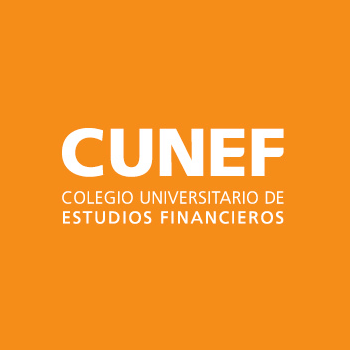
</div>

# **Producto Interior Bruto**

## *Librerías*



In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
from sktime.forecasting.arima import AutoARIMA
from statsmodels.graphics import tsaplots
from sktime.utils.plotting import plot_correlations
from statsmodels.tsa.seasonal import seasonal_decompose
from sktime.transformations.series.boxcox import LogTransformer
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.transformations.series.difference import Differencer
from sktime.utils.plotting import plot_series
from sktime.forecasting.ets import AutoETS
warnings.filterwarnings('ignore')

## *Lectura del CSV y preparación de los datos*
Se procede a leer el archivo CSV del PIB trimestral español:

- Fuente: Instituto Nacional de Estadística (INE)

In [134]:
df_pib = pd.read_csv("pibtrimestral.csv", sep = ";", encoding='latin-1')
df_pib


,Tipo de dato,Agregados macroeconómicos: Nivel 1,Agregados macroeconómicos: Nivel 2,Niveles y tasas,Periodo,total
0,Datos no ajustados de estacionalidad y calendario,Producto interior bruto a precios de mercado,NaN,Dato base,1995T1,109.165
1,Datos no ajustados de estacionalidad y calendario,Producto interior bruto a precios de mercado,NaN,Dato base,1995T2,116.633
2,Datos no ajustados de estacionalidad y calendario,Producto interior bruto a precios de mercado,NaN,Dato base,1995T3,112.398
3,Datos no ajustados de estacionalidad y calendario,Producto interior bruto a precios de mercado,NaN,Dato base,1995T4,122.392
4,Datos no ajustados de estacionalidad y calendario,Producto interior bruto a precios de mercado,NaN,Dato base,1996T1,115.776
...,...,...,...,...,...,...
104,Datos no ajustados de estacionalidad y calendario,Producto interior bruto a precios de mercado,NaN,Dato base,2021T1,279.732
105,Datos no ajustados de estacionalidad y calendario,Producto interior bruto a precios de mercado,NaN,Dato base,2021T2,300.089
106,Datos no ajustados de estacionalidad y calendario,Producto interior bruto a precios de mercado,NaN,Dato base,2021T3,297.498
107,Datos no ajustados de estacionalidad y calendario,Producto interior bruto a precios de mercado,NaN,Dato base,2021T4,327.744


Hacemos una limpieza de columnas y filas para escoger solo el total del PIB desde enero del 2010 hasta el último registro trimestral:

In [135]:
df_pib = df_pib.iloc[60:,-2:]
df_pib.head()

,Periodo,total
60,2010T1,257.598
61,2010T2,273.434
62,2010T3,261.706
63,2010T4,279.971
64,2011T1,258.719


In [136]:
df_pib['Periodo'] = df_pib['Periodo'].str.replace('T', 'Q')
df_pib['Periodo'] = pd.to_datetime(df_pib['Periodo'].str.replace(r'(Q\d) (\d+)', r'\2-\1'), errors= 'coerce')
df_pib.head()

,Periodo,total
60,2010-01-01,257.598
61,2010-04-01,273.434
62,2010-07-01,261.706
63,2010-10-01,279.971
64,2011-01-01,258.719


In [137]:
# convert to period
df_pib['Periodo'] = pd.to_datetime(df_pib['Periodo']).dt.to_period('M')
df_pib = df_pib.set_index('Periodo').resample('M').interpolate()

In [138]:
df_pib

,total
Periodo,
2010-01,257.598000
2010-02,262.876667
2010-03,268.155333
2010-04,273.434000
2010-05,269.524667
...,...
2021-09,317.662000
2021-10,327.744000
2021-11,321.717667



## *Graficación de la serie temporal y análisis*

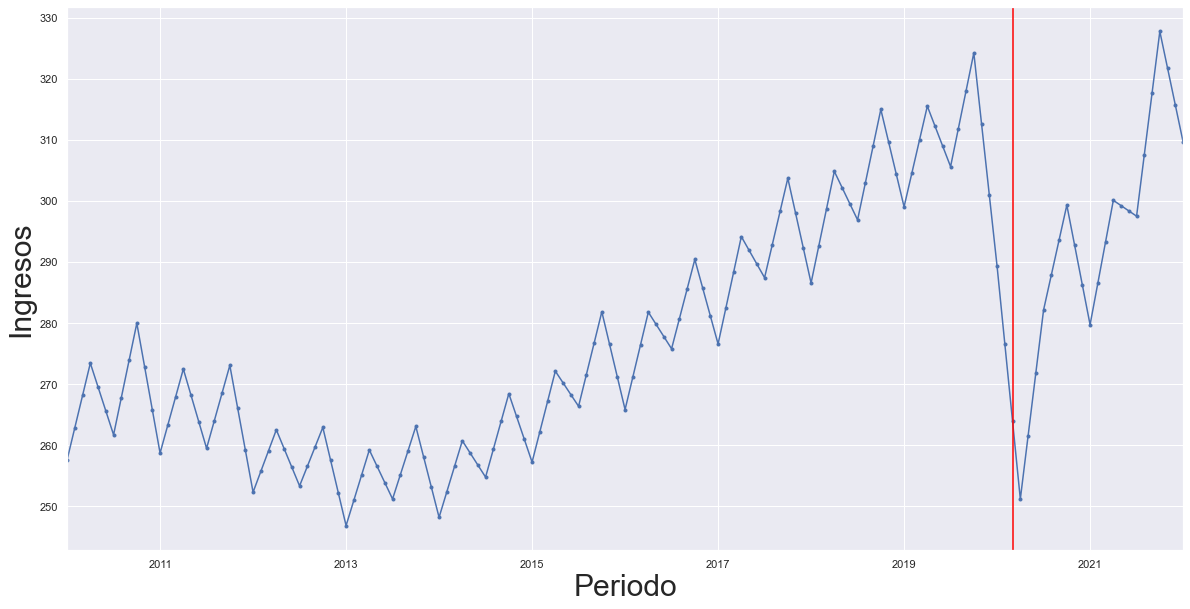

In [139]:
# Ploteamos nuestra serie temporal:
sns.set(rc={'figure.figsize':(20, 10)})
fig = df_pib.total.plot(marker='.') 
fig.set_ylabel('Ingresos', fontsize = 30)
fig.axvline('2020-03-01', color = 'red', linewidth= 1.5)
fig.set_xlabel('Periodo', fontsize = 30);

In [140]:
def split_and_summarize(dataframe, column, size, fn):
    ranges = []
    values = []
    for i in range(0, len(dataframe), size):
        ranges.append(dataframe[i:i + size])
    for i in ranges:
        values.append(fn(i[column]))
    return(values)

In [141]:
mean = split_and_summarize(df_pib, 'total', 4, np.mean)
variance = split_and_summarize(df_pib, 'total', 4, np.var)

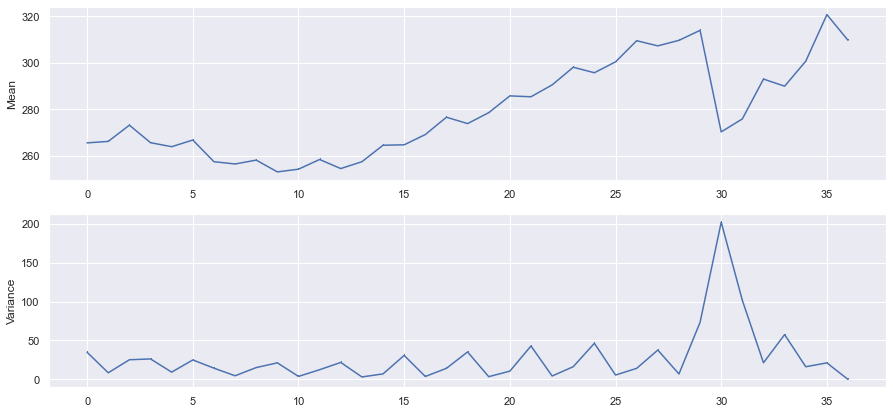

In [142]:
cols = ['mean', 'variance']
df = pd.DataFrame([mean, variance], index=cols)

sns.set(rc={'figure.figsize':(15, 7)})
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(mean, ',-')
ax1.set_ylabel('Mean')

ax2.plot(variance, ',-')
ax2.set_ylabel('Variance')

plt.show()

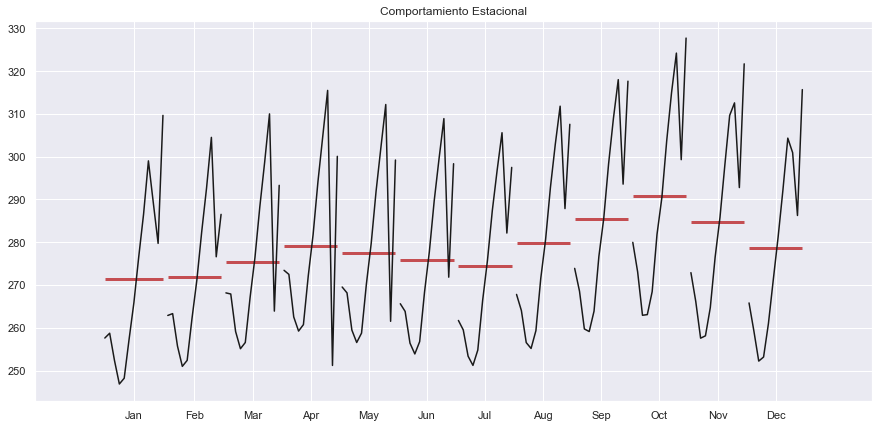

In [143]:
ax = plt.gca()
sm.graphics.tsa.month_plot(df_pib.total, ax=ax)
ax.set_title('Comportamiento Estacional');

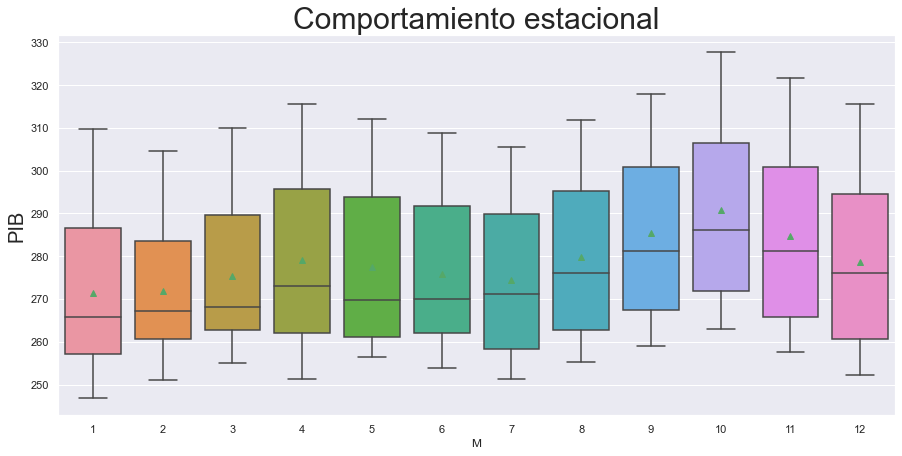

In [144]:
df_pib['M'] = df_pib.index.month
sns.boxplot(data = df_pib, x = 'M', y='total', showmeans=True)
ax = plt.gca()
ax.set_ylabel('PIB', fontsize = 20)
ax.set_title('Comportamiento estacional', fontsize = 30);


TypeError: Axis must have `freq` set to convert to Periods

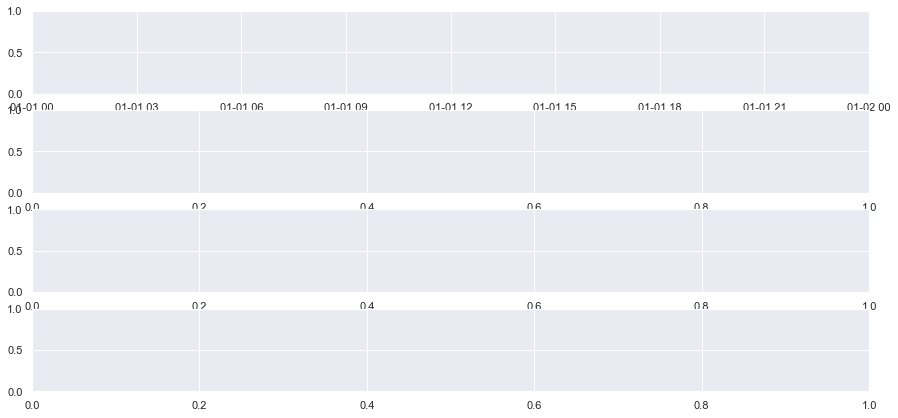

In [150]:

desglose = seasonal_decompose(df_pib.total, 
                              model='additive',
                              extrapolate_trend='freq',
                              period=12);
desglose.plot();